In [1]:
from tf_example.ptb_word_lm import *
import tf_example.reader as reader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_data = reader.ptb_raw_data(FLAGS.data_path)
train_data, valid_data, test_data, _ = raw_data
config = get_config()
eval_config = get_config()
eval_config.batch_size = 1
eval_config.num_steps = 1

In [3]:
sess = tf.InteractiveSession()

In [4]:
initializer = tf.random_uniform_initializer(-config.init_scale,config.init_scale)
with tf.variable_scope("model", reuse=None, initializer=initializer):
    m = PTBModel(is_training=True, config=config)
with tf.variable_scope("model", reuse=True, initializer=initializer):
    mvalid = PTBModel(is_training=False, config=config)
    mtest = PTBModel(is_training=False, config=eval_config)
#tf.initialize_all_variables().run()
ckpt = tf.train.get_checkpoint_state("tf_example/run")
m.saver.restore(sess, ckpt.model_checkpoint_path)

In [12]:
w2d = reader._build_vocab(FLAGS.data_path+'/ptb.train.txt')
d2w = {i:w for w, i in w2d.iteritems()}

In [57]:
attns = []
xs = []
ys = []
state = None
for x, y in reader.ptb_iterator(test_data, mtest.batch_size, mtest.num_steps):
    fetches = [mtest.cost, mtest.final_state, tf.no_op()]
    feed_dict = {}
    feed_dict[mtest.input_data] = x
    feed_dict[mtest.targets] = y
    
    if state is not None:
        for i, (a, hh, c, h) in enumerate(mtest.initial_state):
            feed_dict[a] = state[i][0]
            feed_dict[hh] = state[i][1]
            feed_dict[c] = state[i][2]
            feed_dict[h] = state[i][3]
    
    cost, state, _ = sess.run(fetches, feed_dict)
        
    xs.append(x)
    ys.append(y)
    attns.append(state[0][0])
    
    if len(attns) > 100:
        break

In [58]:
xs = np.squeeze(np.array(xs))
ys = np.squeeze(np.array(ys))
attns = np.squeeze(np.array(attns))

In [100]:
np.max(np.abs(np.reshape(state[0][2], [-1, eval_config.hidden_size])),axis=1)

array([ 0.        ,  0.        ,  0.99999976,  1.98927808,  2.88700008,
        2.14362931,  1.88289452,  2.73457432,  3.60418963,  3.80094218], dtype=float32)

In [101]:
np.max(np.abs(np.reshape(state[0][3], [-1, eval_config.hidden_size])),axis=1)

array([ 0.        ,  0.        ,  0.76148719,  0.96273857,  0.99378169,
        0.92545074,  0.94265407,  0.99038297,  0.99503648,  0.9480496 ], dtype=float32)

In [102]:
state[0][0].T

array([[  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  1.10823335e-03],
       [  1.38804095e-03],
       [  1.57570303e-03],
       [  7.61321047e-04],
       [  5.09278791e-04],
       [  2.04063863e-01],
       [  7.90593565e-01]], dtype=float32)

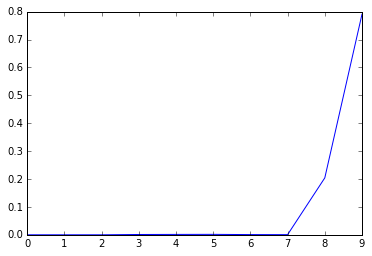

In [103]:
plt.plot(state[0][0].T)

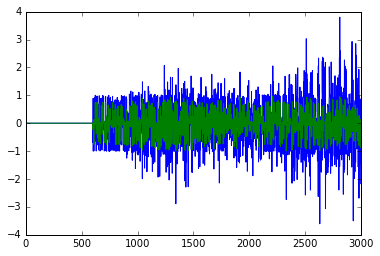

In [104]:
plt.plot(state[0][2].T)
plt.plot(state[0][3].T)

In [59]:
print [d2w[t] for t in list(xs)]
print [d2w[t] for t in list(ys)]

['no', 'it', 'was', "n't", 'black', 'monday', '<eos>', 'but', 'while', 'the', 'new', 'york', 'stock', 'exchange', 'did', "n't", 'fall', 'apart', 'friday', 'as', 'the', 'dow', 'jones', 'industrial', 'average', 'plunged', 'N', 'points', 'most', 'of', 'it', 'in', 'the', 'final', 'hour', 'it', 'barely', 'managed', 'to', 'stay', 'this', 'side', 'of', 'chaos', '<eos>', 'some', 'circuit', 'breakers', 'installed', 'after', 'the', 'october', 'N', 'crash', 'failed', 'their', 'first', 'test', 'traders', 'say', 'unable', 'to', 'cool', 'the', 'selling', 'panic', 'in', 'both', 'stocks', 'and', 'futures', '<eos>', 'the', 'N', 'stock', 'specialist', 'firms', 'on', 'the', 'big', 'board', 'floor', 'the', 'buyers', 'and', 'sellers', 'of', 'last', 'resort', 'who', 'were', 'criticized', 'after', 'the', 'N', 'crash', 'once', 'again', 'could', "n't", 'handle']
['it', 'was', "n't", 'black', 'monday', '<eos>', 'but', 'while', 'the', 'new', 'york', 'stock', 'exchange', 'did', "n't", 'fall', 'apart', 'friday', '

In [60]:
focus = []
for i in range(len(xs)):
    temp = []
    for a_id in range(10):
        if attns[i, a_id] > 0.2:
            temp.append(i-(10-a_id))
    focus.append(temp)

In [61]:
for i in range(len(xs)):
    print d2w[ys[i]], [d2w[ys[t]] for t in focus[i]]

it []
was ['it']
n't ['was']
black ["n't"]
monday ['black']
<eos> ['monday']
but ['monday', '<eos>']
while ['but']
the ['but', 'while']
new ['the']
york ['new']
stock ['the', 'new']
exchange ['stock']
did ['the', 'exchange']
n't ['did']
fall ["n't"]
apart ['fall']
friday ['apart']
as ['apart', 'friday']
the ['friday', 'as']
dow ['the']
jones ['dow']
industrial ['dow', 'jones']
average ['jones', 'industrial']
plunged ['industrial']
N ['plunged']
points ['N']
most ['N']
of ['points', 'most']
it ['of']
in ['most', 'of', 'it']
the ['most', 'in']
final ['it', 'the']
hour ['final']
it ['hour']
barely ['it']
managed ['barely']
to ['barely', 'managed']
stay ['to']
this ['stay']
side ['this']
of ['this', 'side']
chaos ['it', 'this', 'of']
<eos> ['chaos']
some ['of', '<eos>']
circuit ['some']
breakers ['some', 'circuit']
installed ['some', 'circuit', 'breakers']
after ['installed']
the ['installed', 'after']
october ['the']
N ['october']
crash ['N']
failed ['N', 'crash']
their ['failed']
first [